# Visits to Heritage Sites and Archaeological Museums in Pakistan
                                    from 2014 to 2019

                              From Data Extraction to Analysis

This project involves the following:

- **Data Extraction from a complex excel worksheet using pandas and openpyxl**
- **Data Transformation and Cleaning using pandas and regular expressions**
- **Normalization**
- **Database Creation and data population using sqlite and pandas**
- **Data Analysis via SQL, pandas, matplotlib and seaborn**

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
import re
import sqlite3
from sqlite3 import Error

# Data Extraction

The data is contained in an excel file. Merged cells separate the data. Moreover, the merged cells contain details of the year and the site type. A snapshot of the file is as below:

<img src= "Snapshot_of_DataFile.png">

In [202]:
# Read spreadsheet
wb = openpyxl.load_workbook("archaelogical_museums_data.xlsx")
sheet = wb["Table 1"]

# the data is in one spreadsheet, divided by headings
# we'll identify rows which contains the headings and use the row numbers to read the data

new_df_row = []

#loop over the rows, read the cell value. If value contains visitors append to list
for row in range(1, sheet.max_row + 1):
    cell_value = sheet["A" + str(row)].value
    if cell_value:
        if "Visitors" in cell_value:
            new_df_row.append(row)
            #print(cell_value)
            
#read the data using row numbers and store in list

dfs = []

#read the data, create a dataframe for each sub-section and append to the dfs list
for i in range(len(new_df_row)):
    #print(new_df_row[i])
    if i < len(new_df_row)-1:
        data = pd.read_excel("archaelogical_museums_data.xlsx", header = [new_df_row[i], new_df_row[i] + 1], 
                  nrows = (new_df_row[i+1]-1) - (new_df_row[i]+2))
        print(sheet["A" + str(new_df_row[i])].value)
        dfs.append(data)
    else:
        data = pd.read_excel("archaelogical_museums_data.xlsx", header = [new_df_row[i], new_df_row[i] + 1], 
                  nrows = (sheet.max_row) - (new_df_row[i]+2))
        print(sheet["A" + str(new_df_row[i])].value)
        dfs.append(data)

Visitors at Archaeological Museums in Pakistan During January-December, 2014
Visitors at Archaeological Museums in Pakistan During January-December, 2014
Visitors at Heritage Site in Pakistan During January-December, 2014
Visitors at Heritage Site in Pakistan During January-December, 2014
Visitors at Archaeological Museums in Pakistan During January-December, 2015
Visitors at Archaeological Museums in Pakistan During January-December, 2015
Visitors at Heritage Site in Pakistan During January-December, 2015
Visitors at Heritage Site in Pakistan During January-December, 2015
Visitors at Archaeological Museums in Pakistan During January-December, 2016
Visitors at Archaeological Museums in Pakistan During January-December, 2016
Visitors at Heritage Site in Pakistan During January-December, 2016
Visitors at Heritage Site in Pakistan During January-December, 2016
Visitors at Archaeological Museums in Pakistan During January-December, 2017
Visitors at Archaeological Museums in Pakistan During

# Data Transformation

In [203]:
# now that we have all the data in the list (dfs) we need to do some wrangling to develop a usable dataset

#data shows null columns, which have no use so we'll remove them

dfs[0].head()

Area/ attraction                                        \
                   Unnamed: 0_level_1 Unnamed: 1_level_1 Unnamed: 2_level_1   
0                            PAKISTAN                NaN                NaN   
1                           ISLAMABAD                NaN                NaN   
2  Pakistan Museum of Natural History                NaN                NaN   
3           Lok Virsa Heritage Museum                NaN                NaN   
4            Pakistan Monument Museum                NaN                NaN   

    January                                                                    \
  Foreigner Foreigner.1 Foreigner.2 National National.1 National.2 National.3   
0      1101         NaN         NaN   118018        NaN        NaN        NaN   
1       287         NaN         NaN    60306        NaN        NaN        NaN   
2         4         NaN         NaN     5862        NaN        NaN        NaN   
3       177         NaN         NaN    15869        NaN        NaN        NaN   
4       106         NaN         NaN    38575        NaN        NaN        NaN   

   ...         May                                                June  \
   ... Foreigner.2 National National.1 National.2 National.3 Foreigner   
0  ...         NaN   123107        NaN        NaN        NaN       823   
1  ...         NaN    58264        NaN        NaN        NaN       271   
2  ...         NaN     5660        NaN        NaN        NaN        18   
3  ...         NaN     9666        NaN        NaN        NaN       139   
4  ...         NaN    42938        NaN        NaN        NaN       114   

                                              
  Foreigner.1 National National.1 National.2  
0         NaN   140317        NaN        NaN  
1         NaN    68436        NaN        NaN  
2         NaN     8160        NaN        NaN  
3         NaN    15653        NaN        NaN  
4         NaN    44623        NaN        NaN  

[5 rows x 42 columns]

In [204]:
#drop empty columns

for i in range(len(dfs)):
    dfs[i] = dfs[i].dropna(axis = 1, how = "all")

In [205]:
#Convert the data to long format

for i in range(len(dfs)):
    dfs[i] = pd.melt(dfs[i], id_vars = [dfs[i].columns[0]])
    dfs[i] = dfs[i].rename({dfs[i].columns[0]: "site_name","variable_0": "month", \
                         "variable_1": "visitor_type", "value": "num_visitors"}, axis = 1)

In [206]:
dfs[0].head()

,site_name,month,visitor_type,num_visitors
0,PAKISTAN,January,Foreigner,1101
1,ISLAMABAD,January,Foreigner,287
2,Pakistan Museum of Natural History,January,Foreigner,4
3,Lok Virsa Heritage Museum,January,Foreigner,177
4,Pakistan Monument Museum,January,Foreigner,106


In [207]:
#Assign columns for region (province / federal capital), year, site_type

def assign_region(df):
    regions = ["ISLAMABAD", "PUNJAB", "SINDH", "KHYBER PAKHTUNKHWA", "BALOCHISTAN"]
    df["Region"] = 1
    region = "NA"
    for k,v in enumerate(df["site_name"]):
        if v in regions:
            region = v
        df.iloc[k,-1] = region

def assign_year(dfs):
    """
    Takes the list of dataframe, makes a column for the year.
    Since four consecutive dataframes in our list fall within one year, 
    the year variable changes accordingly
    """
    year = 2014
    
    for i in range(len(dfs)):
        if i != 0 and i % 4 == 0:
            year +=1
            dfs[i]["year"] = year
        else:
            dfs[i]["year"] = year

def assign_site_type(dfs):
    """
    Site type changes after every two iterations. We keep track of the change through a variable.
    Consistent with the data extract, if the variable is even we assign the "Archaeological Museum" 
    site type, otherwise we assign the "Heritage Site" site type,
    """
    iteration = 0
    for i in range(len(dfs)):
        if (i!=0) and (i%2 == 0):
            iteration +=1
        if (iteration % 2 != 0):
            dfs[i]["site_type"] = "Heritage Site"
        elif (iteration % 2 == 0):
            dfs[i]["site_type"] = "Archaeological Museum"

In [208]:
# Create the site_type, region and year columns
for i in range(len(dfs)):
    assign_region(dfs[i])

assign_site_type(dfs)

assign_year(dfs)



In [209]:
#dfs now have separate columns for region, year and site_type
dfs[0].head()

,site_name,month,visitor_type,num_visitors,Region,site_type,year
0,PAKISTAN,January,Foreigner,1101,NA,Archaeological Museum,2014
1,ISLAMABAD,January,Foreigner,287,ISLAMABAD,Archaeological Museum,2014
2,Pakistan Museum of Natural History,January,Foreigner,4,ISLAMABAD,Archaeological Museum,2014
3,Lok Virsa Heritage Museum,January,Foreigner,177,ISLAMABAD,Archaeological Museum,2014
4,Pakistan Monument Museum,January,Foreigner,106,ISLAMABAD,Archaeological Museum,2014


In [210]:
#Finally we'll exclude the rows which have aggregates by region and then we'll concatenate the dataframes.

regions = ["PAKISTAN","ISLAMABAD", "PUNJAB", "SINDH", "KHYBER PAKHTUNKHWA", "BALOCHISTAN"]

for i in range(len(dfs)):
    dfs[i] = dfs[i][~(dfs[i]["site_name"].isin(regions))]

data = pd.concat(dfs)

In [211]:
#We now have a SINGLE DATASET with data from 2014-2019, in a usable format.

data.shape

(4872, 7)

# Data Cleaning

The data is dirty. The most glaring issues are as follows:
- same sites sometimes have different spellings
- each site's city is attached with the name - we'll create a separate column for the site's city
- the num_visitors column contains non-numeric data which likely represent no visitors. We'll put 0 in place of these non-numeric entries.

In [212]:
# Identify same sites with different spellings
data.groupby(["Region","site_name"])["num_visitors"].count()

Region              site_name                                 
BALOCHISTAN         Museum Balochistan, Quetta.                   144
ISLAMABAD           Lok Virsa Heritage Museum                     144
                    Pakistan Monument Museum                      144
                    Pakistan Museum of Natural History            144
                    Pakistan Railway Heritage Museum              120
KHYBER PAKHTUNKHWA  Butkara Site Museum, Saidu Sharif, Swat       144
                    Dir Museum,  Chakdara                          24
                    Dir Museum,  Chekdara                         120
                    Julian Site, Haripur                          144
                    Museum Saidu Sharif, Swat.                    144
                    Peshawar Museum, Peshawar.                    144
                    Remains of Takht-i-Bhai, Mardan               144
PUNJAB              Allama Iqbal Library & Museum, Sialkot.       144
                    Allama 

In [213]:
replacements = {"Dir Museum,  Chekdara" : "Dir Museum,  Chakdara ", \
                "Museum, Harappa, District Sahiwal." : "Museum, Harappa, Sahiwal.", \
               "Museum, Bhambore, District Thatta.": "Museum, Banbhore, Thatta.", \
               "Museum,Moenjodaro, Larkana.": "Museum, Moenjodaro, Larkana.", \
               "Museum,Monjodaro, Distric Larkana." : "Museum, Moenjodaro, Larkana.", \
               "Museum Umerkot, District Tharparkar." : "Museum Umerkot,  Tharparkar."}

In [214]:
data["site_name"] = data["site_name"].replace(replacements)
data["site_name"] = data["site_name"].str.strip()

In [215]:
# Checking if the issue is rectified:
data.groupby(["Region","site_name"])["num_visitors"].count()

Region              site_name                                 
BALOCHISTAN         Museum Balochistan, Quetta.                   144
ISLAMABAD           Lok Virsa Heritage Museum                     144
                    Pakistan Monument Museum                      144
                    Pakistan Museum of Natural History            144
                    Pakistan Railway Heritage Museum              120
KHYBER PAKHTUNKHWA  Butkara Site Museum, Saidu Sharif, Swat       144
                    Dir Museum,  Chakdara                         144
                    Julian Site, Haripur                          144
                    Museum Saidu Sharif, Swat.                    144
                    Peshawar Museum, Peshawar.                    144
                    Remains of Takht-i-Bhai, Mardan               144
PUNJAB              Allama Iqbal Library & Museum, Sialkot.       144
                    Allama Iqbal Museum, Javaid Manzil, Lahore    142
                    Harappa

In [216]:
#Next - extract city data from site names

site_names = data["site_name"].value_counts().index

city_name = re.compile(r",\s*([A-Za-z]+).?\s*$")
site_and_city = {}
city_not_found = []

for i in site_names:
    mo = city_name.search(i)
    if mo is not None:
        site_and_city[i] = mo.group(1)
    else:
        city_not_found.append(i)

In [217]:
#The city wasn't detected by the regex for the following entries :

city_not_found

['Lok Virsa Heritage Museum',
 'Pakistan Monument Museum',
 'Lahore Museum Lahore',
 'Pakistan Museum of Natural History',
 'Pakistan Railway Heritage Museum']

In [218]:
#the cities are identified and added to the site_and_city dict, which will be used to map the site_name to city
#in the dataframe

cities = ["Islamabad", "Islamabad", "Islamabad", "Lahore", "Islamabad"]

extra_mapping = dict(zip(city_not_found, cities))
site_and_city.update(extra_mapping)

In [219]:
# create a column for the site's city:

data["site_city"] = data["site_name"].map(site_and_city)

In [220]:
# Remove the city information from the site name

data["site_name"] = (data["site_name"]
                     .str.replace(r",\s*([A-Za-z]+).?\s*$", "")
                     .str.strip())

In [221]:
data.head()

,site_name,month,visitor_type,num_visitors,Region,site_type,year,site_city
2,Pakistan Museum of Natural History,January,Foreigner,4,ISLAMABAD,Archaeological Museum,2014,Lahore
3,Lok Virsa Heritage Museum,January,Foreigner,177,ISLAMABAD,Archaeological Museum,2014,Islamabad
4,Pakistan Monument Museum,January,Foreigner,106,ISLAMABAD,Archaeological Museum,2014,Islamabad
6,Lahore Museum Lahore,January,Foreigner,257,PUNJAB,Archaeological Museum,2014,Islamabad
7,Allama Iqbal Library & Museum,January,Foreigner,4,PUNJAB,Archaeological Museum,2014,Sialkot


In [222]:
# Next dealing with non_numeric value in num_visitors column
non_numeric = [i for i in data["num_visitors"].values if (not isinstance(i,int)) and (not isinstance(i, float))]

print(pd.unique(non_numeric))

['-' '*' 'NIL' 'Nil']


In [223]:
num_visitors_replacements = {"-": 0, "*": 0, "NIL": 0, "Nil":0}

In [224]:
#we are using the assumption that nulls and these other indicators mean 0 visitors

data["num_visitors"] = data["num_visitors"].replace(num_visitors_replacements)

#replace nulls with 0 as well

data["num_visitors"] = data["num_visitors"].fillna(0)

In [225]:
# Formatting the entries in the region column
data["Region"] = data["Region"].str.title()

# Database Creation

Following relational schema created to store the data, after normalizing the existing data table:

<img src = "Museum_Visitors | Relational_Schema.png">

In [226]:
#Let's create a copy of our data.
df = data.copy()

## Isolate the data into separate dataframes as per the schema

In [227]:
location = df.loc[:,["site_city", "Region"]]

#convert the dataframe into a form suitable for entry into a database relation

location = location.drop_duplicates("site_city")
location = location.sort_values(by = "Region")
location["Region"] = location["Region"].str.title()
location["loc_id"] = np.arange(start=1, stop = len(location)+1)
location = location.reset_index(drop = True)
location = location.reindex(["loc_id", "site_city", "Region"], axis = 1)

In [228]:
location.head(3)

,loc_id,site_city,Region
0,1,Quetta,Balochistan
1,2,Lahore,Islamabad
2,3,Islamabad,Islamabad


In [229]:
#mapping to create a foreign key column in the site relation
loc_id_fk = dict(zip(location["site_city"], location["loc_id"]))

In [230]:
site = df.loc[:,["site_name", "site_type", "site_city"]]

site = (site
        .drop_duplicates("site_name")
        .reset_index(drop = True))

site["loc_id"] = site["site_city"].map(loc_id_fk)
site.drop("site_city", axis =1, inplace = True)
site["site_id"] = np.arange(start=1, stop = len(site)+1)
site = site.reindex(["site_id", "site_name", "site_type", "loc_id"], axis = 1)

In [231]:
site.head(3)

,site_id,site_name,site_type,loc_id
0,1,Pakistan Museum of Natural History,Archaeological Museum,2
1,2,Lok Virsa Heritage Museum,Archaeological Museum,3
2,3,Pakistan Monument Museum,Archaeological Museum,3


In [232]:
#mapping to create a foreign key column in the visit relation
site_id_fk = dict(zip(site["site_name"], site["site_id"]))

In [233]:
visit = df.loc[:, ["visitor_type", "month", "year", "num_visitors", "site_name"]]

visit = visit.reset_index(drop = True)

visit["site_id"] = visit["site_name"].map(site_id_fk)
visit.drop("site_name", axis = 1, inplace = True)

In [234]:
visit.head(3)

,visitor_type,month,year,num_visitors,site_id
0,Foreigner,January,2014,4.0,1
1,Foreigner,January,2014,177.0,2
2,Foreigner,January,2014,106.0,3


## Create Database

In [238]:

def create_connection(db_file):
    """Create a database connection to a SQLite database"""
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print("Connection successful.")
        return conn
    except Error as e:
        print(e)

            
def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
        
def main():
    db = "museum_visitors.db"
    
    sql_create_location_table = """ CREATE TABLE IF NOT EXISTS location(
        loc_id integer PRIMARY KEY,
        site_city text NOT NULL,
        region text NOT NULL);"""


    sql_create_site_table = """CREATE TABLE IF NOT EXISTS site(
        site_id integer PRIMARY KEY,
        site_name text NOT NULL,
        site_type text NOT NULL,
        loc_id integer NOT NULL,
        FOREIGN KEY (loc_id) REFERENCES location(loc_id));"""


    sql_create_visit_table = """CREATE TABLE IF NOT EXISTS visit(
        visitor_type text NOT NULL,
        month text NOT NULL,
        year integer NOT NULL,
        num_visitors real NOT NULL,
        site_id integer NOT NULL,
        PRIMARY KEY(visitor_type, month, year, site_id),
        FOREIGN KEY (site_id) REFERENCES site(site_id));"""

    conn = create_connection(db)
    
    if conn is not None:
        #Create the location table
        create_table(conn, sql_create_location_table)
        
        #Create the site table
        create_table(conn, sql_create_site_table)
        
        #Create the Visit table
        create_table(conn, sql_create_visit_table)
    else:
        print("Error! Cannot create the database connection")



In [239]:
# let's run the main function to create the database and the relations

main()

Connection successful.


In [240]:
#Checking if intended tables created, also creating a cursor object for later use.
conn = create_connection("museum_visitors.db")
c = conn.cursor()
c.execute("SELECT name FROM sqlite_master WHERE type='table';")
c.fetchall()

Connection successful.


[('location',), ('site',), ('visit',)]

## Insert Data

In [241]:
for i in range(len(location)):
        c.execute("""INSERT INTO location(
                loc_id, site_city, region) VALUES 
                (%d, '%s', '%s')""" % ((location["loc_id"][i]), location["site_city"][i], location["Region"][i]))
        
print("Populated the location table")

for i in range(len(site)):
     c.execute("""INSERT INTO site(
                site_id, site_name, site_type, loc_id) VALUES 
                (%d, '%s', '%s', %d)""" % ((site["site_id"][i]), site["site_name"][i], site["site_type"][i],\
                                                 site["loc_id"][i]))
print("Populated the site table")


for i in range(len(visit)):
    c.execute("""INSERT INTO visit(
                visitor_type, month, year, num_visitors, site_id) VALUES 
                ('%s', '%s', %d, %d, %d)""" % ((visit["visitor_type"][i]), visit["month"][i], visit["year"][i],\
                                                 visit["num_visitors"][i], visit["site_id"][i]))

print("Populated the visit table")

Populated the location table
Populated the site table
Populated the visit table


In [242]:
# commit the changes
conn.commit()

# Data Analysis


With our database populated, we will use SQL to analyze the data and to find engaging insights.

## Over this time frame, were there more visitors to archaeological sites or to heritage museums?

In [243]:
query_1 = """

SELECT sum(num_visitors) AS Total_Visitors, site_type AS Site_Type
FROM site, visit
WHERE site.site_id = visit.site_id
GROUP BY site_type
ORDER BY Total_Visitors desc;

"""

In [244]:
output_1 = pd.read_sql(query_1,conn)
result = output_1.copy()
result["Total_Visitors"] = result.apply(lambda x: "{:,}".format(x["Total_Visitors"]), axis = 1)
result

,Total_Visitors,Site_Type
0,"23,237,985.0",Heritage Site
1,"13,929,427.0",Archaeological Museum


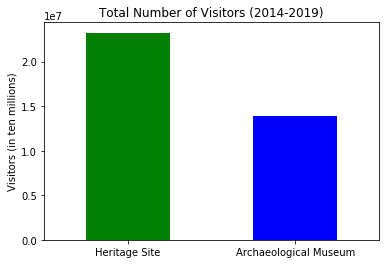

In [245]:
%matplotlib inline
ax = output_1.plot.bar(x = "Site_Type", y = "Total_Visitors", legend = False, color = ["g", "b"], rot = 0)

props = {"title": "Total Number of Visitors (2014-2019)", "xlabel": "", \
         "ylabel": "Visitors (in ten millions)"}

ax = ax.set(**props)


### Finding:

Visitors to Heritage Sites outpaced visitors to Archaeological Museums

## What was the trend in visitors to Heritage Sites and Archaeological Museums over this time frame?

In [246]:
query_2a = """

SELECT sum(num_visitors) AS Total_Visitors, year As Year
FROM site, visit
WHERE site.site_id = visit.site_id
AND site_type = "Heritage Site"
GROUP BY Year

"""

Trend in visitors to Heritage Sites

In [247]:
output_2a = pd.read_sql(query_2a, conn)
result_2a = output_2a.copy()
result_2a["Total_Visitors"] = result_2a.apply(lambda x: "{:,}".format(x["Total_Visitors"]), axis = 1)
result_2a

,Total_Visitors,Year
0,"1,594,769.0",2014
1,"2,003,782.0",2015
2,"3,195,965.0",2016
3,"4,204,958.0",2017
4,"6,636,623.0",2018
5,"5,601,888.0",2019


In [251]:
query_2b = """

SELECT sum(num_visitors) AS Total_Visitors, year As Year
FROM site, visit
WHERE site.site_id = visit.site_id
AND site_type = "Archaeological Museum"
GROUP BY Year

"""

Trend in visitors to Archaeological Museums

In [253]:
output_2b = pd.read_sql(query_2b, conn)
result_2b = output_2b.copy()
result_2b["Total_Visitors"] = result_2b.apply(lambda x: "{:,}".format(x["Total_Visitors"]), axis = 1)
result_2b

,Total_Visitors,Year
0,"1,774,298.0",2014
1,"1,973,144.0",2015
2,"2,239,129.0",2016
3,"2,356,441.0",2017
4,"2,691,182.0",2018
5,"2,895,233.0",2019


Plotting the trends together

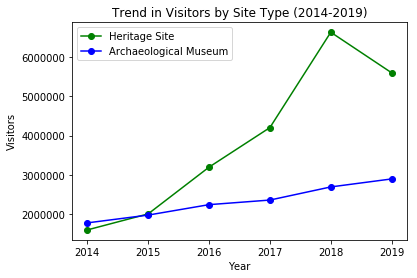

In [269]:
fig, ax = plt.subplots(1,1)

ax.plot(output_2a["Year"], output_2a["Total_Visitors"], marker = "o", color = "g", label = "Heritage Site")
ax.plot(output_2b["Year"], output_2b["Total_Visitors"], marker = "o", color = "b", label = "Archaeological Museum")
ax.legend()

props = {"title": "Trend in Visitors by Site Type (2014-2019)", "xlabel": "Year", "ylabel": "Visitors"}
ax = ax.set(**props)

### Finding:

While there is significant growth in visitors to heritage sites, the growth in visitors to archaeological museums is meagre. It is interesting to note that visits to Archaeological Museums outpaced visits to Heritage Sites in 2014. This should spur research into why museums didn't see an uptick comparable to heritage sites over this time period.

## What is the distribution of destinations by region?

In [389]:
query_3 = """

SELECT region, site_type , count(site_type) as num_destinations
FROM site, location
WHERE site.loc_id = location.loc_id
GROUP BY region, site_type
"""

Distribution by region

In [390]:
output_3 = pd.read_sql(query_3, conn)

output_3

,region,site_type,num_destinations
0,Balochistan,Archaeological Museum,1
1,Islamabad,Archaeological Museum,6
2,Islamabad,Heritage Site,3
3,Khyber Pakhtunkhwa,Archaeological Museum,3
4,Khyber Pakhtunkhwa,Heritage Site,3
5,Punjab,Archaeological Museum,4
6,Punjab,Heritage Site,3
7,Sindh,Archaeological Museum,8
8,Sindh,Heritage Site,4


Plotting the distribution

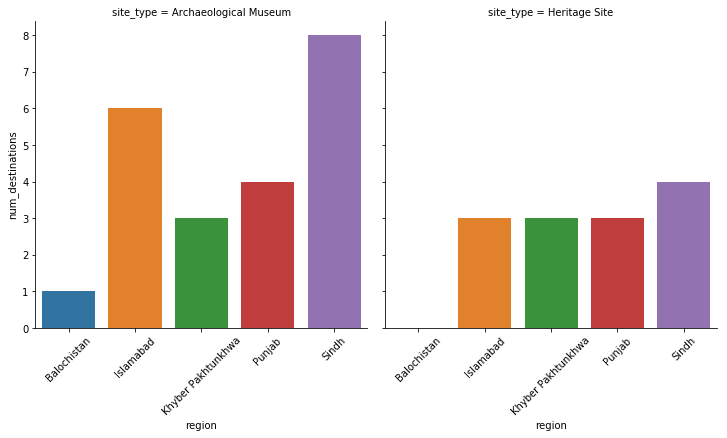

In [463]:
g = sns.catplot(x = "region", y = "num_destinations", col = "site_type", kind = "bar", data = output_3)

g = g.set_xticklabels(
    labels=["Balochistan", "Islamabad", "Khyber Pakhtunkhwa", "Punjab", "Sindh"], rotation= 45)


### Finding:

Most of the destinations are in Sindh, which is followed by the Federal Capital, Islamabad. 

# What was the trend in number of visitors by region?

Does it correlate with the distribution of destinations (i.e. do regions with more destinations have a higher number of visitors?)

In [471]:
#Extract data on total visitors grouped by the region and the year

query_4 = """

SELECT region, year, sum(num_visitors) as total_visitors
FROM location, site, visit
WHERE location.loc_id = site.loc_id
AND site.site_id = visit.site_id
GROUP BY region, year


"""

In [472]:
output_4 = pd.read_sql(query_4, conn)
output_4.head()

,region,year,total_visitors
0,Balochistan,2014,954.0
1,Balochistan,2015,1124.0
2,Balochistan,2016,1298.0
3,Balochistan,2017,1533.0
4,Balochistan,2018,1632.0


There is a significant difference in the number of visitors by regions. Plotting on one graph doesn't show the trend correctly because of the spread of values on the y-axis, so we'll plot multiple graphs to clearly visualize the trends.

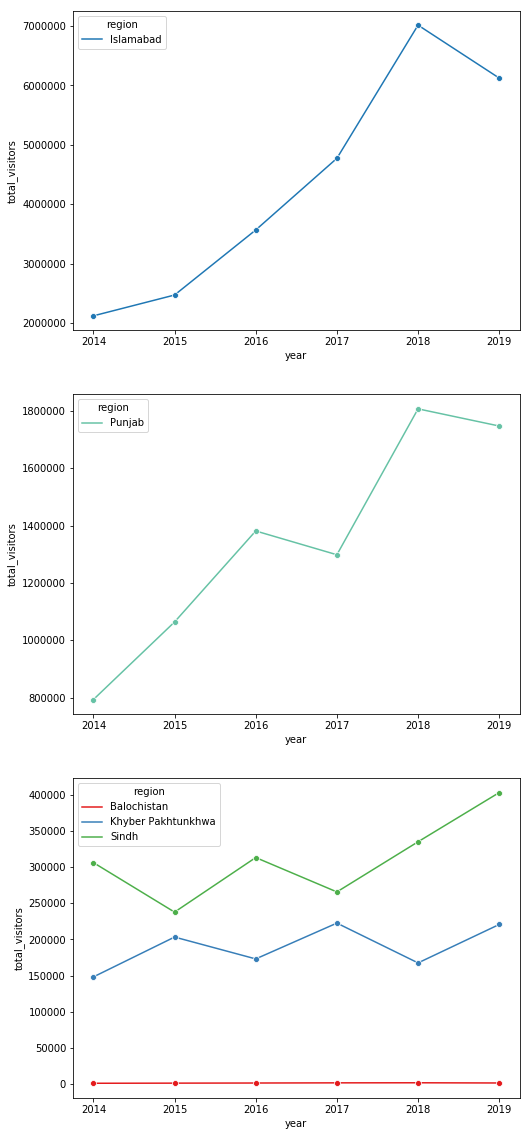

In [561]:
%matplotlib inline

#isolating data for plots
df_1 = output_4[(output_4["region"] == "Islamabad")]
df_2 = output_4[output_4["region"] == "Punjab"]
df_3 = output_4[~((output_4["region"] == "Islamabad") | (output_4["region"] == "Punjab"))]

# create plots

plt.figure(figsize = (8,20))

plt.subplot(3,1,1)
sns.lineplot(x = "year", y = "total_visitors", hue = "region", marker = "o", data = df_1)

plt.subplot(3,1,2)
sns.lineplot(x = "year", y = "total_visitors", palette = "Set2", hue = "region", marker = "o", data = df_2)

plt.subplot(3,1,3)
sns.lineplot(x = "year", y = "total_visitors", palette = "Set1", hue = "region", marker = "o", data = df_3)



### Finding

The number of destinations per region doesn't seem to correlate with the number of visitors by region. Islamabad had more visitors than Sindh, though Sindh has more destinations. Second, whereas there is growth in the number of visitors for some regions, this upward trend isn't observed for others. 

# Suggestions for further analysis


In this project, we created a clean and usable dataset and developed some insights on visits to archaeological museums and heritage sites in Pakistan. The data reveals interesting patterns such as visits to heritage museums outpacing visits to archaeological museums after 2014 and lack of a correlation between the number of destinations and number of visitors by region.

For further analysis, we can investigate the trends observed and pinpoint which destinations contributed to the growth in visitors and which destinations lagged behind. Successful tourist spots can provide information on incentives or factors that encouraged visits, which can then be replicated to promote other destinations and increase tourism. An analysis of visitors by visitor type (foreign or national) can also help in growing domestic and foreign tourism.
